In [1]:
!pip install pandas matplotlib numpy

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [3]:
df = pd.read_csv("Startdata.csv", delimiter=',')
print(df.head())
print(df.columns.tolist())

   Device_type            Timestamp Heart rate  Activity type Sleep stage  \
0  Apple Watch  20250602074248+0200         42              0       Awake   
1  Apple Watch  20250602074813+0200         58              1       Awake   
2  Apple Watch  20250602075146+0200         60              1       Awake   
3  Apple Watch  20250602075658+0200         75              0       Awake   
4  Apple Watch  20250602080402+0200         84              0       Awake   

   Coffee  
0       0  
1       0  
2       0  
3       0  
4       0  
['Device_type', 'Timestamp', 'Heart rate', 'Activity type', 'Sleep stage', 'Coffee']


### pre-preprocessing

In [4]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y%m%d%H%M%S%z", errors="coerce")
df["Heart rate"] = pd.to_numeric(df["Heart rate"], errors="coerce")
df["Activity type"] = df["Activity type"].astype("category")

In [5]:
# How many coffee values are there? 16
print((df["Coffee"] != 0).sum())

# Transform Coffee -> Caffeine left in body
half_life, dose = 5, 75
events, caffeine_left = [], []

for t, c in zip(df["Timestamp"], df["Coffee"]):
    events = [(et, d) for et, d in events if (t - et).total_seconds() < 24*3600]
    total = sum(d * 0.5 ** ((t - et).total_seconds() / 3600 / half_life) for et, d in events)
    if c == 1.0:
        events.append((t, dose))
        total += dose
    caffeine_left.append(total)

df["Caffeine"] = pd.Series(caffeine_left).round(3)

# Clean Caffeine Column
df["Caffeine"] = pd.to_numeric(df["Caffeine"], errors="coerce").fillna(0).astype(float)

# Example
# for ts, val in df.loc[df["Caffeine"] > 0, ["Timestamp", "Caffeine"]].values:
#     print(ts.strftime("%Y-%m-%d %H:%M"), val)

coffee = df["Coffee"]
time = df["Timestamp"]
print(df["Sleep stage"].unique())

16
['Awake' 'Light' 'Deep' 'REM']


In [6]:
def plot_feature(feature, cat=False):

    # Ignore Missing Values
    f = df[feature]
    if cat: f = df[feature].astype("category").cat.add_categories("Unknown").fillna("Unknown")

    # Choose Color
    color_dict = {
    "Heart rate": "deepskyblue",
    "Caffeine": "brown",
    "Activity type": "darkorange",
    "Sleep stage": "purple"}
    color = color_dict.get(feature, "blue")

    # Plot
    fig, axs = plt.subplots(figsize=(14, 5))
    axs.plot(df["Timestamp"], f, color=color)
    axs.set_xlabel("Time", fontsize=16)
    axs.set_ylabel(f"{feature} Level", fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f"{feature}_over_time.png", dpi=300)
    plt.show()

# plot_feature("Caffeine")
# plot_feature('Heart rate')
# plot_feature('Activity type', True)


# 2. Exploratory Data Analysis
<!-- <h1 style="color:darkblue;">2. Exploratory Data Analysis</h1> -->

### Plot Activity-Type, Sleep-Stage counts 

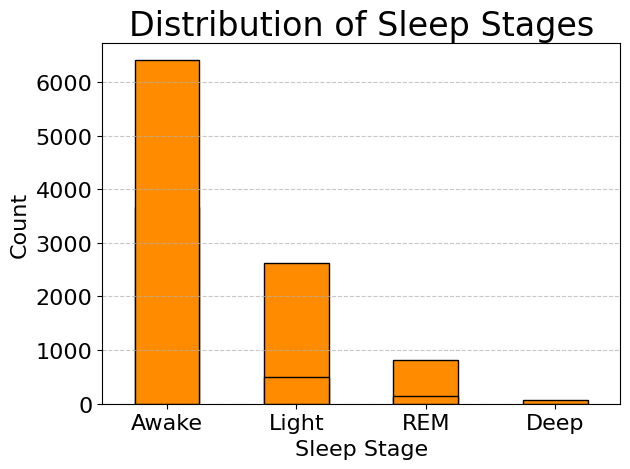

In [7]:
#Activity type
activity_counts = df["Activity type"].value_counts(dropna=False)
activity_counts.index = activity_counts.index.fillna("Missing")
activity_counts.plot(kind='bar', color='darkorange', edgecolor='black')
plt.xlabel("Activity Type", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Distribution of Activity Types", fontsize=24)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(os.path.expanduser('~/Desktop/activity_type.png'), dpi=300)
# plt.show()

#Sleep stage
activity_counts = df["Sleep stage"].value_counts(dropna=False)
activity_counts.index = activity_counts.index.fillna("Missing")
activity_counts.plot(kind='bar', color='darkorange', edgecolor='black')
plt.xlabel("Sleep Stage", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Distribution of Sleep Stages", fontsize=24)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(os.path.expanduser('~/Desktop/sleep_stage.png'), dpi=300)
# plt.show()


### Create various intervals (5min, 10min, 15min)

In [8]:
#Creating various intervals
def resample_df(df, interval="10min"):
    """
    Resample numerical and categorical columns in a time-indexed DataFrame.

    Parameters:
        df (pd.DataFrame): Input dataframe with a 'Timestamp' column.
        interval (str): Time interval string for resampling (e.g., '10min', '1H').

    Returns:
        pd.DataFrame: Resampled dataframe with 'Timestamp' as a column.
    """
    # Ensure Timestamp is parsed and set as index
    df = df.copy()
    df.columns = df.columns.str.strip()
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    df["Heart rate"] = pd.to_numeric(df["Heart rate"], errors="coerce")
    df = df.set_index("Timestamp").sort_index()

    # Define columns
    numerical_cols = ["Heart rate"]
    categorical_cols = ["Activity type", "Sleep stage", "Caffeine"]

    # Convert categoricals to string to avoid numeric aggregation
    for col in categorical_cols:
        df[col] = df[col].astype(str)

    # Resample numericals using mean
    numerical_resampled = df[numerical_cols].resample(interval).mean()

    # Resample categoricals using mode
    print(df["Sleep stage"].unique())
    categorical_resampled = pd.DataFrame(index=numerical_resampled.index)
    for col in categorical_cols:
        categorical_resampled[col] = df[col].resample(interval).agg(
            lambda x: x.mode().iloc[0] if not x.mode().empty else None
        )

    for col in categorical_cols:
        categorical_resampled[col] = categorical_resampled[col].replace(['None', 'nan', None], np.nan)
        categorical_resampled[col] = categorical_resampled[col].ffill().bfill()
    print(df["Sleep stage"].unique())
    
    # Combine and reset index
    df_resampled = pd.concat([numerical_resampled, categorical_resampled], axis=1).reset_index()
    print(df_resampled["Sleep stage"].unique())
    return df_resampled

df_5min = resample_df(df, "5min")
df_10min = resample_df(df, "10min")
df_15min = resample_df(df, "15min")


['Awake' 'Light' 'Deep' 'REM']
['Awake' 'Light' 'Deep' 'REM']
['Awake' 'Light' 'Deep' 'REM']
['Awake' 'Light' 'Deep' 'REM']
['Awake' 'Light' 'Deep' 'REM']
['Awake' 'Light' 'Deep' 'REM']
['Awake' 'Light' 'Deep' 'REM']
['Awake' 'Light' 'Deep' 'REM']
['Awake' 'Light' 'Deep' 'REM']


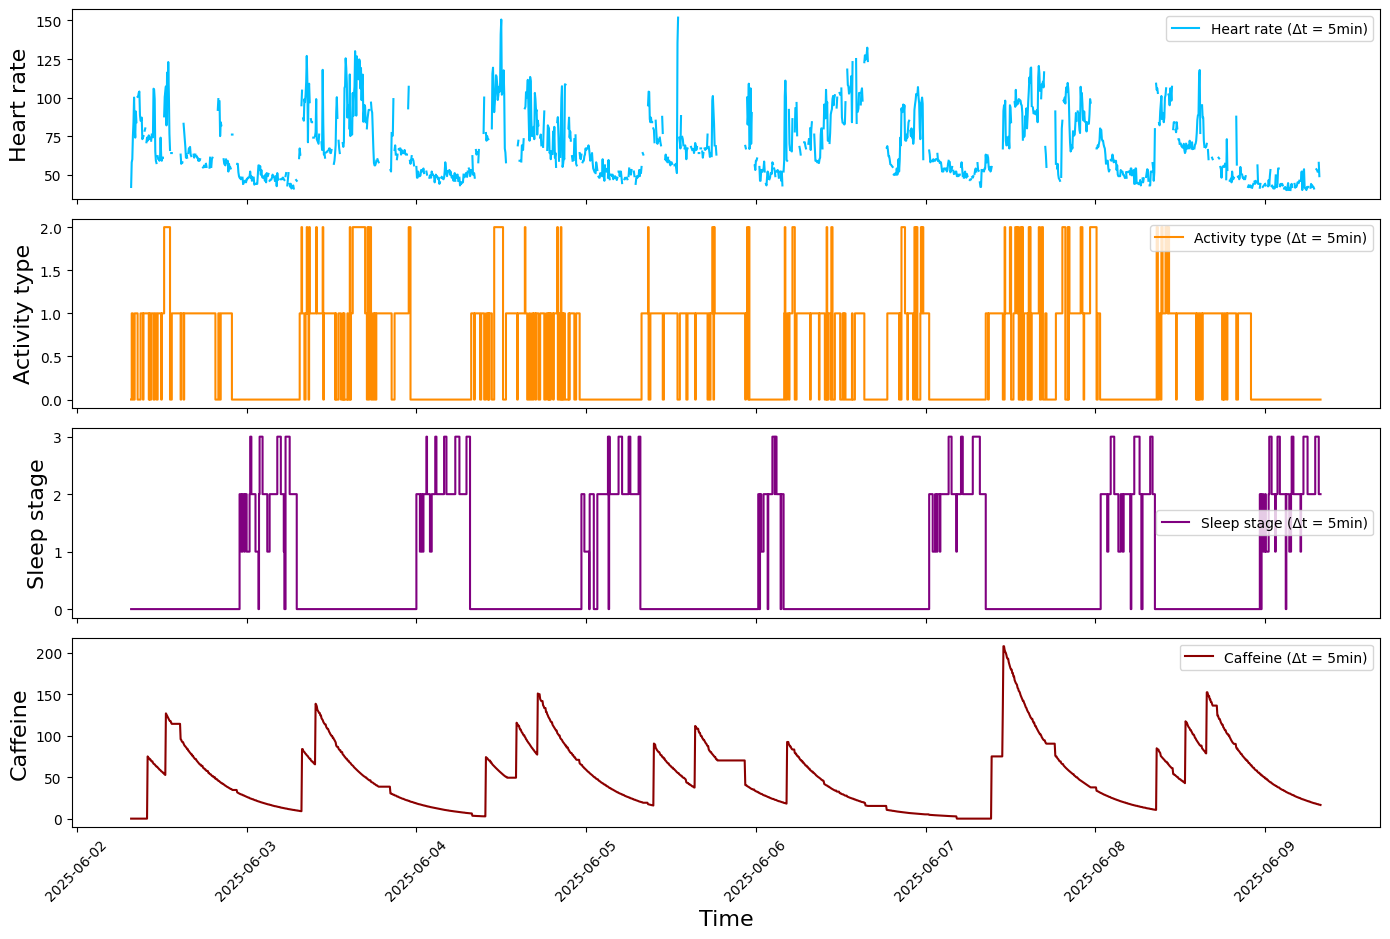

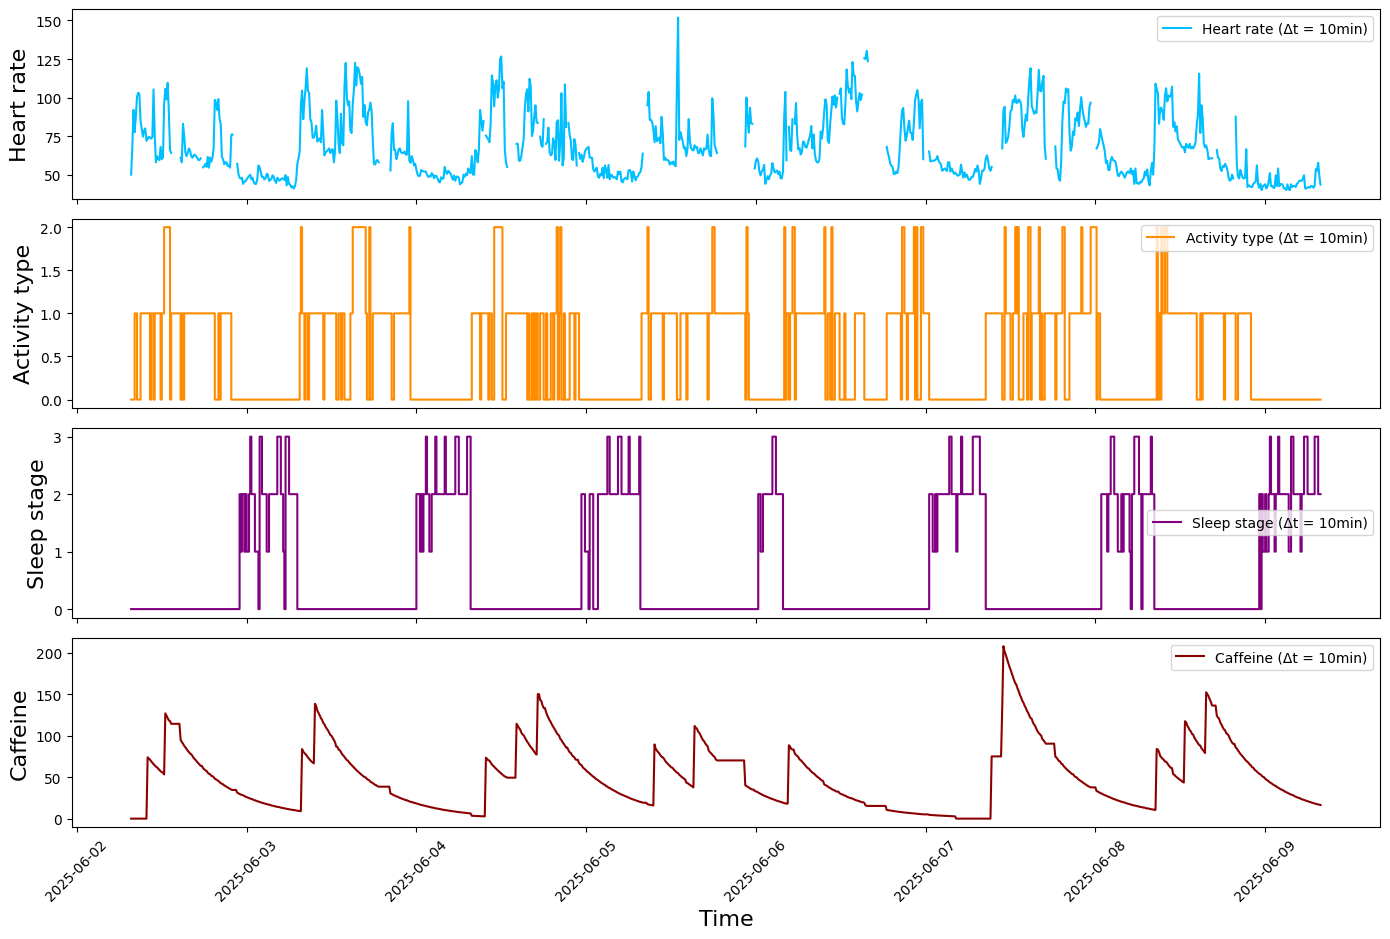

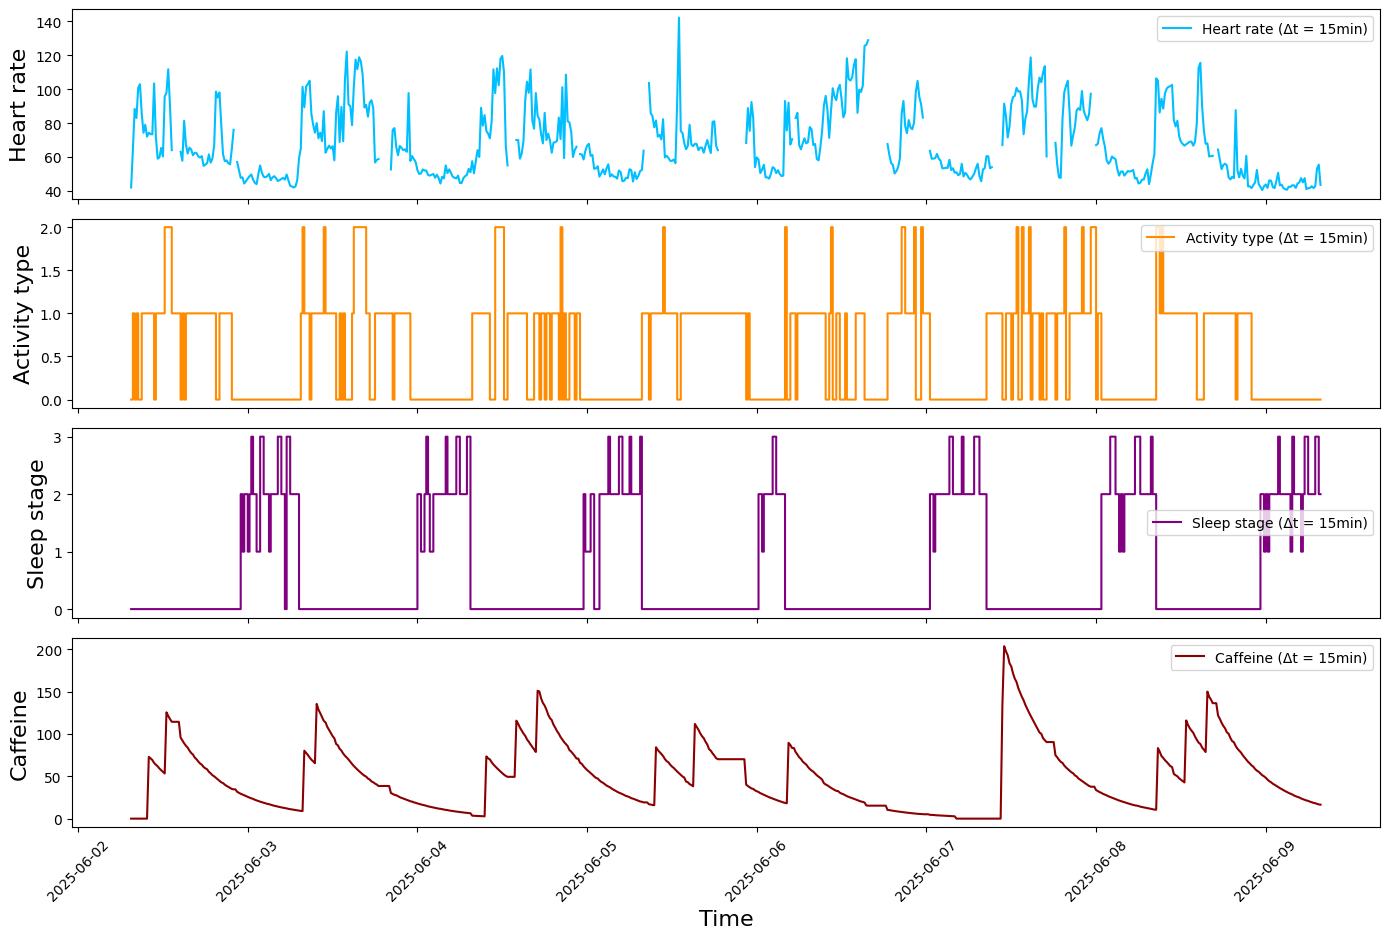

In [9]:
def plot_sensor_overview(df_resampled, interval_label="10min", save_path="/Users/dora/Desktop/timeseries_plot.png"):
    """
    Plots 4 sensor/categorical measurements over time in subplots.
    
    Parameters:
        df_resampled (pd.DataFrame): Resampled dataframe with 'Timestamp' as a column.
        interval_label (str): Label for the time interval (e.g., '10min') to show in the title and legends.
        save_path (str): File path to save the resulting plot image.
    """

    # Ensure timestamp is in datetime format and set as index
    df_resampled = df_resampled.copy()
    df_resampled["Timestamp"] = pd.to_datetime(df_resampled["Timestamp"], errors="coerce")
    df_resampled = df_resampled.set_index("Timestamp")

    # Clean caffeine column
    df_resampled["Caffeine"] = pd.to_numeric(df_resampled["Caffeine"], errors="coerce")

    # Set up figure and axes
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True)

    # Plot 1: Heart rate
    axs[0].plot(df_resampled.index,
                df_resampled["Heart rate"],
                label=f"Heart rate (Δt = {interval_label})",
                color='deepskyblue')
    axs[0].set_ylabel("Heart rate", fontsize=16)
    axs[0].legend()

    # Plot 2: Activity type
    axs[1].plot(df_resampled.index,
                pd.to_numeric(df_resampled["Activity type"], errors='coerce'),
                drawstyle='steps-post',
                label=f"Activity type (Δt = {interval_label})",
                color='darkorange')
    axs[1].set_ylabel("Activity type", fontsize=16)
    axs[1].legend()

    # Plot 3: Sleep stage
    axs[2].plot(df_resampled.index,
                df_resampled["Sleep stage"].astype("category").cat.codes,
                drawstyle='steps-post',
                label=f"Sleep stage (Δt = {interval_label})",
                color='purple')
    axs[2].set_ylabel("Sleep stage", fontsize=16)
    axs[2].legend()

    # Plot 4: Caffeine
    axs[3].plot(df_resampled.index,
                df_resampled["Caffeine"],
                label=f"Caffeine (Δt = {interval_label})",
                color='darkred')
    axs[3].set_ylabel("Caffeine", fontsize=16)
    axs[3].legend()

    # Final formatting
    axs[-1].set_xlabel("Time", fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leaves space for suptitle
    plt.savefig(save_path, dpi=300)
    # plt.show()

plot_sensor_overview(df_5min, interval_label="5min", save_path=os.path.expanduser('~/Desktop/5.png'))
plot_sensor_overview(df_10min, interval_label="10min", save_path=os.path.expanduser('~/Desktop/10.png'))
plot_sensor_overview(df_15min, interval_label="15min", save_path=os.path.expanduser('~/Desktop/15.png'))

In [10]:
#For further anlysis we use df_10min
df = df_10min
print(df.isna().sum())

Timestamp          0
Heart rate       105
Activity type      0
Sleep stage        0
Caffeine           0
dtype: int64


# 3. Data Preprocessing
<!-- <h1 style="color:darkblue;">3. Data Preprocessing</h1> -->

### Data Cleaning

In [11]:
df["Caffeine"] = pd.to_numeric(df["Caffeine"], errors="coerce")

### Outlier Removal

In [12]:
lower, upper = df['Heart rate'].quantile([0.01, 0.99])
df['Heart rate'] = df['Heart rate'].clip(lower, upper)

### Imputation

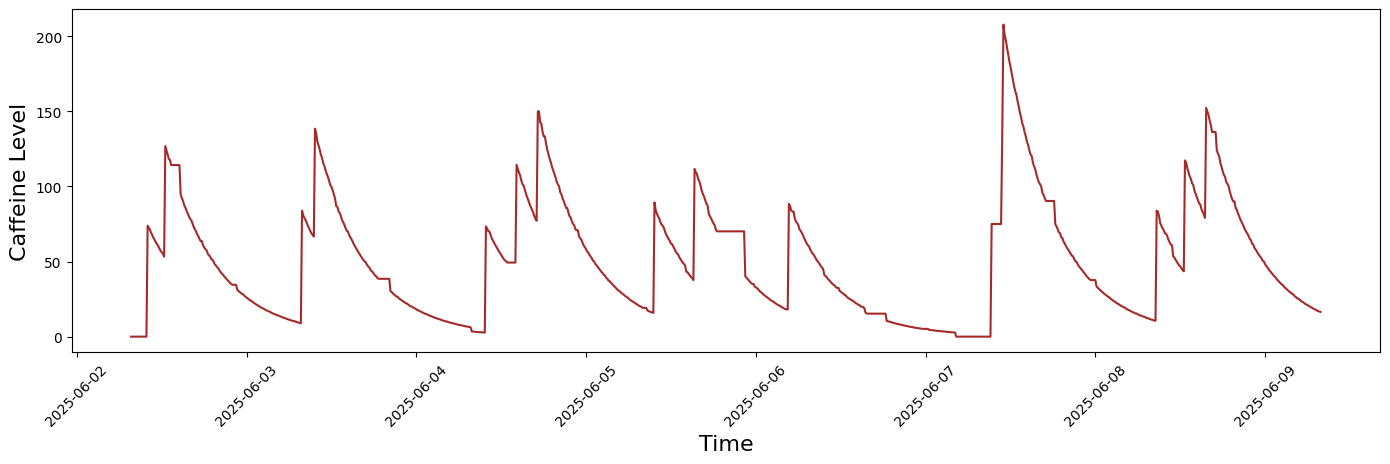

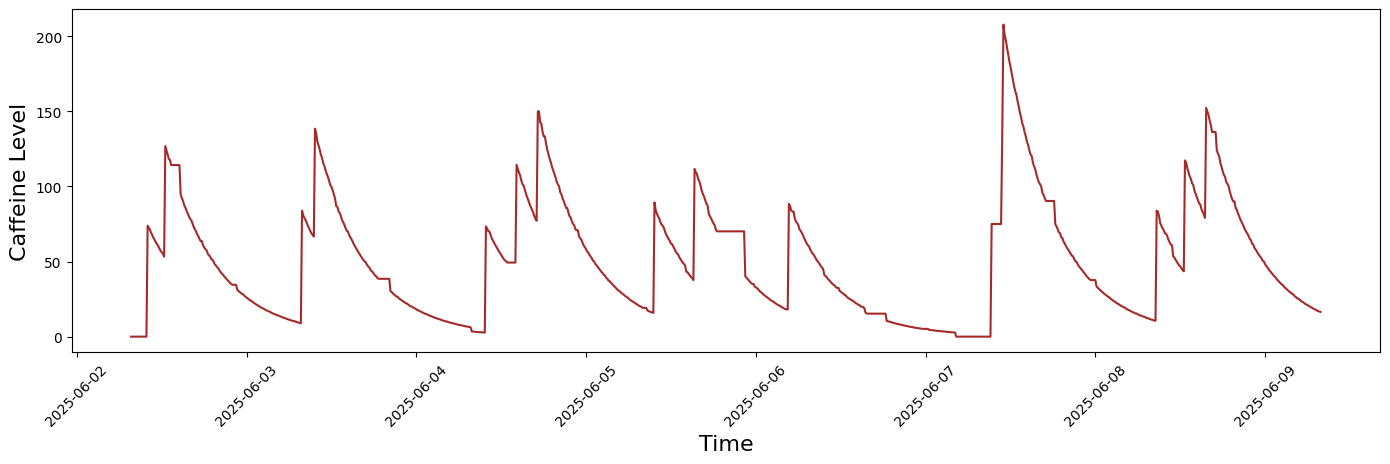

In [13]:
# Linear Interpolation

# Heart rate
# plot_feature('Heart rate')
df['Heart rate'] = df['Heart rate'].interpolate()
# plot_feature('Heart rate')

# Caffeine
plot_feature('Caffeine')
df['Caffeine'] = df['Caffeine'].interpolate()
plot_feature('Caffeine')

# Activity Type
# plot_feature('Activity type', True)
df['Activity type'] = df['Activity type'].fillna(df['Activity type'].mode()[0])
# plot_feature('Activity type', True)

### Kalman Filter (smooths out heart rate)

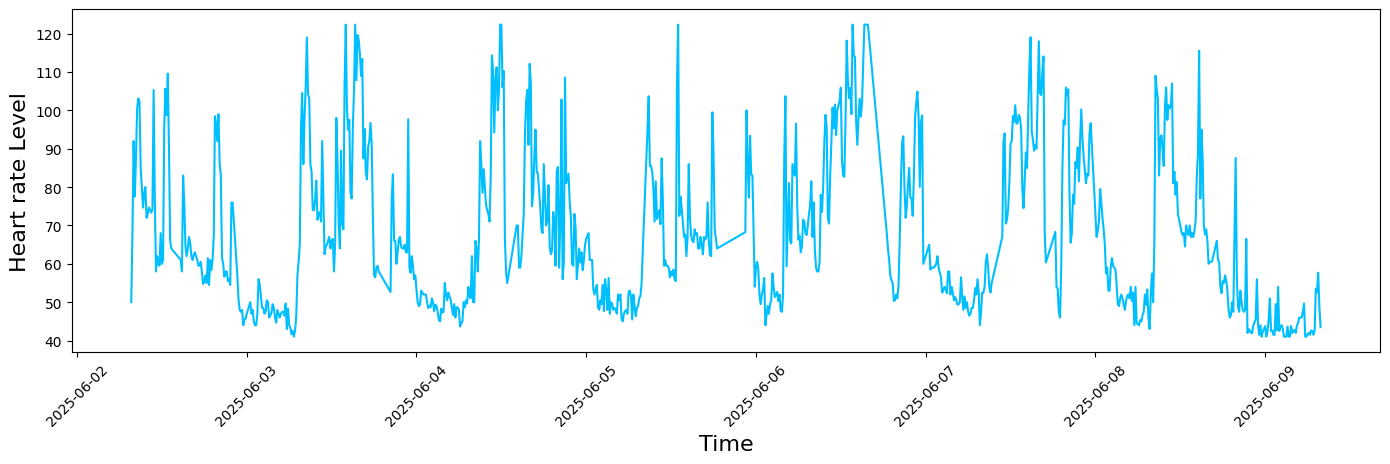

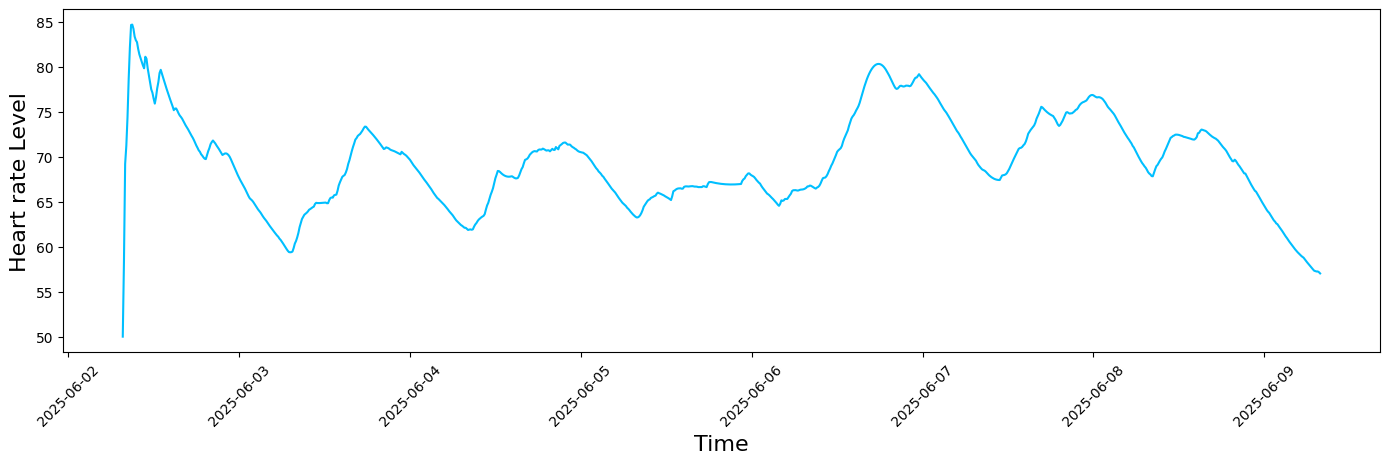

In [14]:
def kalman_1d(zs, Q=1e-5, R=0.1):
    x = zs[0]
    P = 1.0
    filtered = []
    for z in zs:
        # Predict
        P += Q
        # Update
        K = P / (P + R)
        x += K * (z - x)
        P *= (1 - K)
        filtered.append(x)
    return filtered

plot_feature('Heart rate')
df['Heart rate'] = kalman_1d(df['Heart rate'].values)
plot_feature('Heart rate')

# 4. Feature Engineering

### Time -> (Day-of-Week, Hour, Minute)

In [15]:
df["hour"] = df["Timestamp"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)  # Cyclic
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)  # Cyclic
df["minute"] = df["Timestamp"].dt.minute
df["day_of_week"] = df["Timestamp"].dt.dayofweek 

### Caffeine -> (Hours-since-Caffeine)

In [16]:
# Make sure timestamps are datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
time = pd.to_datetime(time)

# Get timestamps where coffee == 1
coffee_times = [t for t, c in zip(time, coffee) if c == 1]

# Compute hours since last caffeine
last = None
hours_since = []

for t in df["Timestamp"]:
    eligible = [ct for ct in coffee_times if ct <= t]
    if eligible:
        last = max(eligible)
        hours_since.append(0 if t == last else (t - last).total_seconds() / 3600)
    elif last:
        hours_since.append((t - last).total_seconds() / 3600)
    else:
        hours_since.append(-1)

df["hours_since_caffeine"] = hours_since

print(hours_since)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0.13805555555555554, 0.3047222222222222, 0.4713888888888889, 0.6380555555555556, 0.8047222222222222, 0.9713888888888889, 1.1380555555555556, 1.3047222222222221, 1.4713888888888889, 1.6380555555555556, 1.8047222222222221, 1.9713888888888889, 2.1380555555555554, 2.3047222222222223, 2.471388888888889, 0.015, 0.18166666666666667, 0.34833333333333333, 0.515, 0.6816666666666666, 0.8483333333333334, 1.015, 1.1816666666666666, 1.3483333333333334, 1.515, 1.6816666666666666, 1.8483333333333334, 2.015, 2.1816666666666666, 2.348333333333333, 2.515, 2.6816666666666666, 2.848333333333333, 3.015, 3.1816666666666666, 3.348333333333333, 3.515, 3.6816666666666666, 3.848333333333333, 4.015, 4.181666666666667, 4.348333333333334, 4.515, 4.681666666666667, 4.848333333333334, 5.015, 5.181666666666667, 5.348333333333334, 5.515, 5.681666666666667, 5.848333333333334, 6.015, 6.181666666666667, 6.348333333333334, 6.515, 6.681666666666667, 6.848333333333

### Heart Rate -> (rolling_mean/std/min/max/range, change, percent-change, low-medium-high)

In [17]:
n = 5
df["hr_rolling_mean"] = df["Heart rate"].rolling(window=n, min_periods=1).mean()  # smooths heart rate (trend)
df["hr_rolling_std"] = df["Heart rate"].rolling(window=n, min_periods=1).std().fillna(0)    # heart rate variability (volatility)
df["hr_min"] = df["Heart rate"].rolling(window=n, min_periods=1).min()         # rolling minimum over n points
df["hr_max"] = df["Heart rate"].rolling(window=n, min_periods=1).max()         # rolling maximum over n points
df["hr_range"] = df["hr_max"] - df["hr_min"]                                   # range in n-point window
df["hr_diff"] = df["Heart rate"].diff().fillna(0)                              # immediate heart rate change
df["hr_pct_change"] = df["Heart rate"].pct_change().fillna(0)                  # relative heart rate change (%)
df["hr_level"] = pd.cut(df["Heart rate"], bins=[0, 60, 90, np.inf], labels=["low", "medium", "high"]) 
df["hr_level"] = df["hr_level"].cat.codes  # converts to 0,1,2 numeric

### Sleep stage -> categorical

In [18]:
print(df["Sleep stage"].unique())

df["Sleep stage"] = df["Sleep stage"].astype("category").cat.codes



['Awake' 'Light' 'Deep' 'REM']


## Feature Selection

In [19]:
# Overview
features = df.columns.tolist()
features = [
    'Timestamp', "hour", "hour_sin", "hour_cos", "minute", "day_of_week",
    'Heart rate', "hr_rolling_mean", "hr_rolling_std", "hr_min", "hr_max", "hr_range", "hr_diff", "hr_pct_change", "hr_level",
    'Activity type', 
    'Sleep stage',
    'Caffeine']

# Define
target_feature = 'Sleep stage'
time_features = ['Timestamp', "hour", "hour_sin", "hour_cos", "minute", "day_of_week"]

# Select
class_features = df.drop(columns=time_features + [target_feature])
lstm_features = df.drop(columns=['Timestamp'] + [target_feature])

In [20]:
# Print NaN values
for feature in features:
    nan_count = lstm_features.isna().sum()
    print(f" {nan_count} NaNs: {feature}")

 Heart rate              0
Activity type           0
Caffeine                0
hour                    0
hour_sin                0
hour_cos                0
minute                  0
day_of_week             0
hours_since_caffeine    0
hr_rolling_mean         0
hr_rolling_std          0
hr_min                  0
hr_max                  0
hr_range                0
hr_diff                 0
hr_pct_change           0
hr_level                0
dtype: int64 NaNs: Timestamp
 Heart rate              0
Activity type           0
Caffeine                0
hour                    0
hour_sin                0
hour_cos                0
minute                  0
day_of_week             0
hours_since_caffeine    0
hr_rolling_mean         0
hr_rolling_std          0
hr_min                  0
hr_max                  0
hr_range                0
hr_diff                 0
hr_pct_change           0
hr_level                0
dtype: int64 NaNs: hour
 Heart rate              0
Activity type           0
Caffeine

# 5. Model: LSTM

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [22]:
# Define the LSTM classification model
def lstm_classification(X_train, X_test, y_train, y_test, input_shape, num_classes, epochs=50, batch_size=32, patience=3):
    # Prepare y_train for classification
    y_train_class = to_categorical(y_train, num_classes=num_classes)

    # Define model
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.6))
    model.add(LSTM(16, return_sequences=False))
    model.add(Dropout(0.6))
    model.add(Dense(num_classes, activation='softmax'))  # Change to 'softmax' for classification

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])  # Categorical loss for multi-class

    # Define early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)



    balanced = True

    if balanced:
        # Compute class weights
        from sklearn.utils import class_weight
        weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weights = dict(enumerate(weights))
        
        
        # Train the model with early stopping
        history = model.fit(X_train, y_train_class, epochs=epochs, batch_size=batch_size,
                            validation_split=0.2, callbacks=[early_stop], class_weight=class_weights)

    else:       
        # Train the model with early stopping
        history = model.fit(X_train, y_train_class, epochs=epochs, batch_size=batch_size,
                            validation_split=0.2, callbacks=[early_stop])
        

    # Get training and validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get training and validation accuracy
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    print("History keys:", history.history.keys())
    print("Train loss:", history.history['loss'])
    print("Val loss:", history.history['val_loss'])

    
    # Plot the loss
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot the accuracy
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
    plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Get predictions and classification report
    y_pred = model.predict(X_test)
    y_pred_class = y_pred.argmax(axis=-1)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred_class, target_names=[f'Class {i}' for i in range(num_classes)]))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_class)

    class_names = ['Awake', 'Light', 'Deep', 'REM']
    order = [0, 1, 3, 2]  # Move 'Deep' (index 2) to last
    
    cm_reordered = cm[np.ix_(order, order)]
    class_names_reordered = [class_names[i] for i in order]
    
    sns.heatmap(cm_reordered, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names_reordered, yticklabels=class_names_reordered)


    # # Plot confusion matrix
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(num_classes)],
    #             yticklabels=[f'Class {i}' for i in range(num_classes)])


    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return model

False False
hours_since_caffeine


2025-06-18 01:17:54.994768: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-18 01:17:54.994797: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-18 01:17:54.994802: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1750202274.995494 13005732 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750202274.995932 13005732 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/philipvacca/tf-env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model in

Epoch 1/50


2025-06-18 01:17:55.527539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3022 - loss: 1.3694 - val_accuracy: 0.7019 - val_loss: 1.2984
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4676 - loss: 1.2949 - val_accuracy: 0.7516 - val_loss: 1.2235
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5369 - loss: 1.2825 - val_accuracy: 0.7453 - val_loss: 1.1288
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5881 - loss: 1.1535 - val_accuracy: 0.7143 - val_loss: 1.0299
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6529 - loss: 1.1726 - val_accuracy: 0.6646 - val_loss: 0.9247
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6874 - loss: 1.2035 - val_accuracy: 0.6770 - val_loss: 0.8246
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6755 - loss: 1.1073 - val_accuracy: 0.6894 - val_loss: 0.7446
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7161 - loss: 1.0568 - val_accuracy: 0.6957 - val_loss: 0.

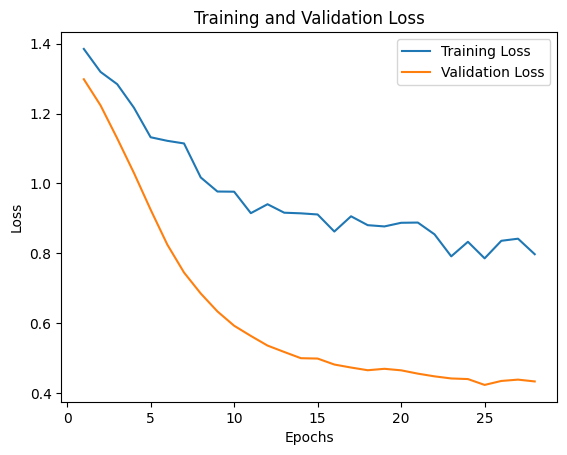

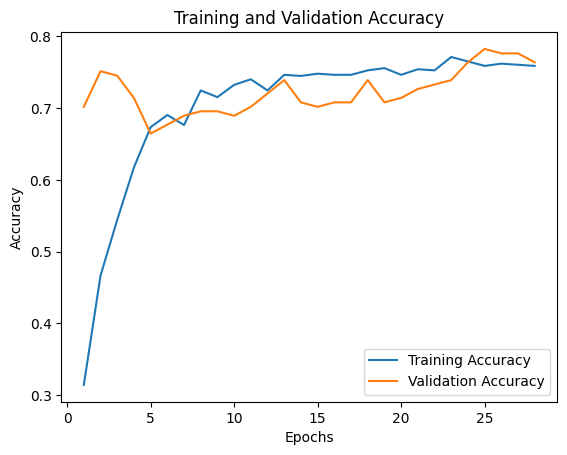

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.92      0.96       141
     Class 1       0.12      0.50      0.20         8
     Class 2       0.50      0.14      0.22        42
     Class 3       0.11      0.27      0.16        11

    accuracy                           0.71       202
   macro avg       0.43      0.46      0.38       202
weighted avg       0.81      0.71      0.73       202



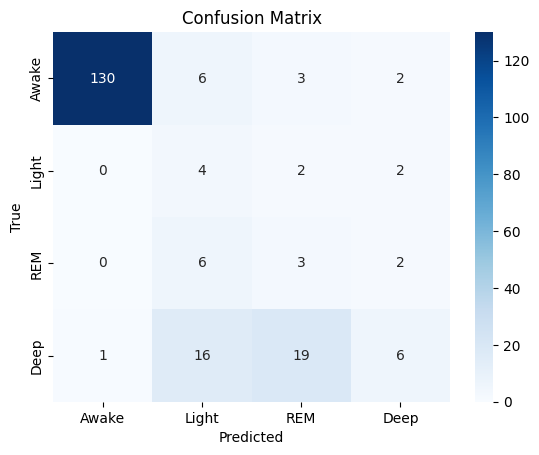

In [23]:
# Prepare data
X = lstm_features.values
y = df['Sleep stage'].values
num_classes = len(np.unique(y))
X = X.astype(np.float64)

def create_sequences(X, y, seq_length=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length + 1):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length-1])  # label of last timestep
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, seq_length=5)

# Scale sequences correctly: scale feature-wise per timestep
# Flatten to 2D for scaler, then reshape back
nsamples, ntimesteps, nfeatures = X_seq.shape
X_seq_2d = X_seq.reshape(-1, nfeatures)
scaler = StandardScaler()
X_seq_2d = scaler.fit_transform(X_seq_2d)
X_seq_scaled = X_seq_2d.reshape(nsamples, ntimesteps, nfeatures)

# Train-test split on sequences and labels
X_train, X_test, y_train, y_test = train_test_split(X_seq_scaled, y_seq, stratify=y_seq, test_size=0.2, random_state=42)

print(np.isnan(X_train).any(), np.isinf(X_train).any())
print(lstm_features.columns[8])

# Train and evaluate
model = lstm_classification(X_train, X_test, y_train, y_test,
                            input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=num_classes)

In [24]:
# import numpy as np
# import shap

# # Flatten sequence input: (samples, seq_len, features) -> (samples, seq_len*features)
# background_data_flat = background_data.reshape(background_data.shape[0], -1)
# test_data_flat = test_data.reshape(test_data.shape[0], -1)

# # Define a wrapper prediction function that reshapes input back to 3D for the model
# def f(x):
#     x_reshaped = x.reshape(x.shape[0], background_data.shape[1], background_data.shape[2])
#     return model.predict(x_reshaped)

# explainer = shap.KernelExplainer(f, background_data_flat)
# shap_values = explainer.shap_values(test_data_flat)

# # shap_values will be flat, reshape back if needed for feature interpretation

In [25]:
# # shap_values shape: (samples, seq_len * features)
# # Reshape to (samples, seq_len, features)
# shap_values_reshaped = np.array(shap_values).reshape(-1, background_data.shape[1], background_data.shape[2])

# # Aggregate over time steps to get per-feature importance
# feature_importance = np.mean(np.abs(shap_values_reshaped), axis=1)  # shape: (samples, features)

# # Then average over samples for global feature importance
# global_feature_importance = np.mean(feature_importance, axis=0)  # shape: (features,)

# print(global_feature_importance)

# important_indices = [4, 3, 5, 6, 12]

# for i in important_indices:
#     print(lstm_features.columns[i])

In [26]:
from sklearn.metrics import balanced_accuracy_score, f1_score

def evaluate_classification(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    balanced_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)  # balanced F1

    print(f"{model_name} Classification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Balanced F1-Score (macro): {balanced_f1:.4f}")

In [27]:
# 2B EVALUATION
# Predict
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert from one-hot/probabilities
y_true = y_test

# Evaluate
evaluate_classification(y_true, y_pred, model_name="LSTM Model")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
LSTM Model Classification Results:
Accuracy: 0.7079
Precision: 0.8077
Recall: 0.7079
F1-Score (weighted): 0.7299
Balanced Accuracy: 0.4594
Balanced F1-Score (macro): 0.3840
